In [2]:
import os
import cv2
import numpy as np

def load_dataset(base_path, img_size=(128, 128)):
    """
    Memuat gambar dan mask dari dataset terstruktur.
    
    Args:
        base_path (str): Path ke folder utama (training/testing/validation).
        img_size (tuple): Ukuran gambar setelah resize (default: (128, 128)).
    
    Returns:
        Tuple: (images, masks)
    """
    rgb_path = os.path.join(base_path, "rgb")
    label_path = os.path.join(base_path, "label")
    
    images, masks = [], []
    
    for filename in os.listdir(rgb_path):
        # Load RGB image
        img = cv2.imread(os.path.join(rgb_path, filename))
        img = cv2.resize(img, img_size) / 255.0  # Normalize
        images.append(img)
        
        # Load corresponding label
        mask = cv2.imread(os.path.join(label_path, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0  # Normalize
        masks.append(np.expand_dims(mask, axis=-1))  # Add channel dimension
    
    return np.array(images), np.array(masks)

# Contoh penggunaan:
train_images, train_masks = load_dataset("C://Users//Muhammad Sheva//Documents\Kuliah//Semester 5//Computer Vision//Tugas//Tugas Sesi 12//pothole600//training")
val_images, val_masks = load_dataset("C://Users//Muhammad Sheva//Documents\Kuliah//Semester 5//Computer Vision//Tugas//Tugas Sesi 12//pothole600//validation")
test_images, test_masks = load_dataset("C://Users//Muhammad Sheva//Documents\Kuliah//Semester 5//Computer Vision//Tugas//Tugas Sesi 12//pothole600//testing")

print(f"Train: {train_images.shape}, {train_masks.shape}")
print(f"Validation: {val_images.shape}, {val_masks.shape}")
print(f"Test: {test_images.shape}, {test_masks.shape}")


Train: (240, 128, 128, 3), (240, 128, 128, 1)
Validation: (180, 128, 128, 3), (180, 128, 128, 1)
Test: (180, 128, 128, 3), (180, 128, 128, 1)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt

In [4]:
# 2. Build U-Net model
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = UpSampling2D((2, 2))(c3)
    u1 = Concatenate()([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = UpSampling2D((2, 2))(c4)
    u2 = Concatenate()([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    return Model(inputs, outputs)

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Checkpoint untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    "best_model.keras",  # Ganti .h5 dengan .keras
    monitor="val_loss",
    save_best_only=True
)

# Compile model
model.compile(
    optimizer="adam",  # Anda bisa mengganti optimizer sesuai kebutuhan
    loss="binary_crossentropy",  # Pilih loss yang sesuai dengan tugas Anda
    metrics=["accuracy"]  # Tambahkan metrik yang diinginkan
)
# Melatih model
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=5,
    batch_size=16,
    callbacks=[checkpoint]
)



Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.9159 - loss: 0.4073 - val_accuracy: 0.9702 - val_loss: 0.1401
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.9162 - loss: 0.2625 - val_accuracy: 0.9702 - val_loss: 0.1257
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9098 - loss: 0.2689 - val_accuracy: 0.9702 - val_loss: 0.1274
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9207 - loss: 0.2384 - val_accuracy: 0.9702 - val_loss: 0.1225
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.9275 - loss: 0.2294 - val_accuracy: 0.9702 - val_loss: 0.1141


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9391 - loss: 0.1918
Test Loss: 0.2855185568332672, Test Accuracy: 0.9067857265472412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


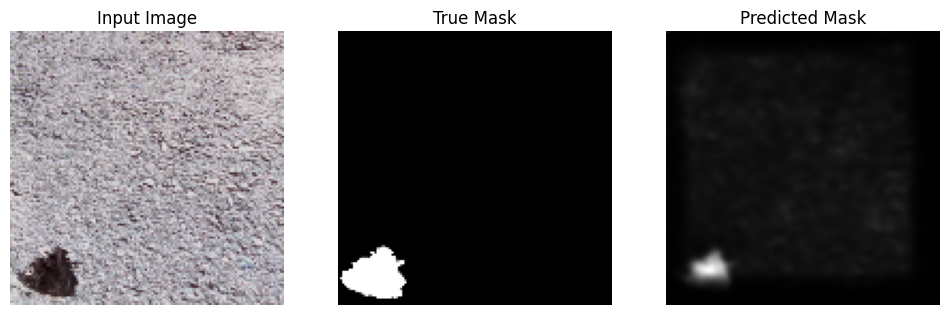

In [6]:
# Evaluasi pada data testing
test_loss, test_acc = model.evaluate(test_images, test_masks)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Visualisasi hasil
def plot_sample(image, true_mask, pred_mask=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.axis('off')
    
    if pred_mask is not None:
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Prediksi pada gambar uji
test_image = test_images[0] #test dengan data 1
true_mask = test_masks[0]
pred_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

plot_sample(test_image, true_mask, pred_mask)


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9391 - loss: 0.1918
Loaded Model Test Loss: 0.2855185568332672, Test Accuracy: 0.9067857265472412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


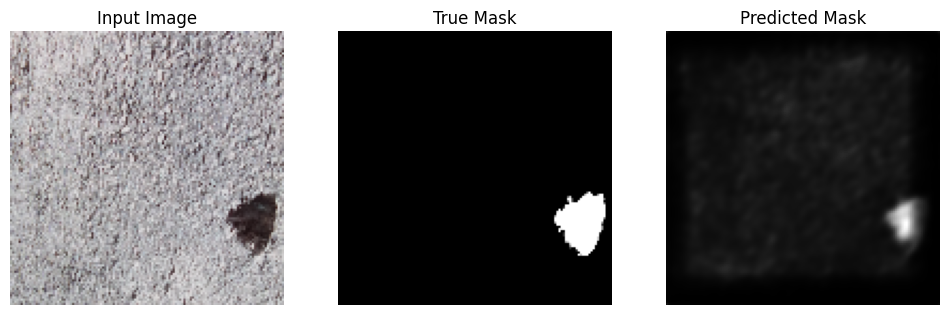

In [7]:
from tensorflow.keras.models import load_model

# Load model terbaik
model = load_model("best_model.keras")

# Evaluasi model
loss, accuracy = model.evaluate(test_images, test_masks)
print(f"Loaded Model Test Loss: {loss}, Test Accuracy: {accuracy}")

# Prediksi pada gambar baru
pred_mask = model.predict(np.expand_dims(test_images[1], axis=0))[0]
plot_sample(test_images[1], test_masks[1], pred_mask)


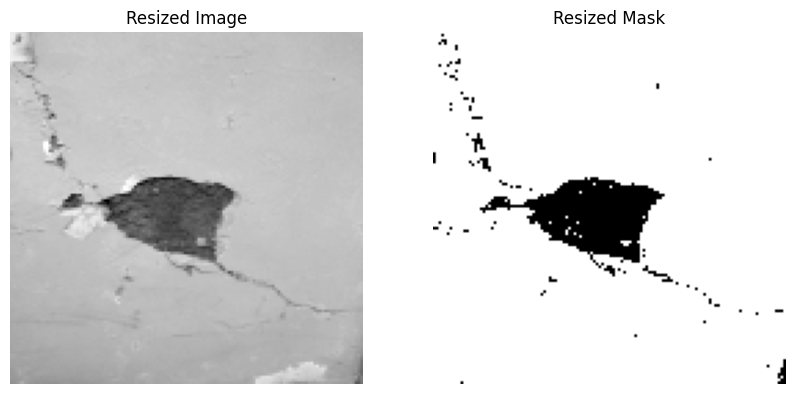

In [8]:
#membuat masking dari input gambar
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load gambar
image = cv2.imread("C://Users//Muhammad Sheva//Documents\Kuliah//Semester 5//Computer Vision//Tugas//Tugas Sesi 12//example.jpg", cv2.IMREAD_GRAYSCALE)

# Thresholding untuk membuat mask
_, mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

def resize_image_and_mask(image, mask, size=(128, 128)):
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    resized_mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return resized_image, resized_mask


# Resize gambar dan mask
resized_image, resized_mask = resize_image_and_mask(image, mask)

# Visualisasi
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Resized Image")
plt.imshow(resized_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Resized Mask")
plt.imshow(resized_mask, cmap='gray')
plt.axis('off')

plt.show()
